In [136]:
import os
import requests, tarfile
CURRENT_DIR = os.getcwd()
print(CURRENT_DIR)

/mnt/c/Box/CISC704-HW/HW1


In [137]:
CIFAR_DIR = os.path.join(CURRENT_DIR, 'data','cifar')
print(CIFAR_DIR)
def download_CIFAR(path=CIFAR_DIR, url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', redownload=False):
    if os.path.exists(path) and redownload is False:
        print('Dataset already exists')
        return
    print('Downloading...')
    r = requests.get(url, stream=True)
    # show download progress
    total_length = r.headers.get('content-length')
    with open('cifar-10-python.tar.gz', 'wb') as f:
        if total_length is None: # no content length header
            f.write(r.content)
        else:
            dl = 0
            total_length = int(total_length)
            for chunk in r.iter_content(chunk_size=1024):
                dl += len(chunk)
                f.write(chunk)
                done = int(50 * dl / total_length)
                print('\r[{}{}]'.format('=' * done, ' ' * (50-done)), end='')
    print('\nExtracting...')
    with tarfile.open('cifar-10-python.tar.gz') as f:
        f.extractall(path)
    print('Done!')

download_CIFAR()

/mnt/c/Box/CISC704-HW/HW1/data/cifar
Dataset already exists


In [138]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin')
    return dict

In [139]:
# load meta data
meta = unpickle(os.path.join(CIFAR_DIR, 'cifar-10-batches-py', 'batches.meta'))
print(meta['label_names'])

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [140]:
# load all train data and combine all data them into one
import numpy as np
train_files = ['data_batch_{}'.format(i) for i in range(1,6)]
print(train_files)
train_data = [unpickle(os.path.join(CIFAR_DIR, 'cifar-10-batches-py', f)) for f in train_files]

train_imgs = np.vstack([d['data'] for d in train_data])
train_labels = np.hstack([d['labels'] for d in train_data])

print(train_imgs.shape, train_labels.shape)

['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
(50000, 3072) (50000,)


In [141]:
# load all test data
test_data = unpickle(os.path.join(CIFAR_DIR, 'cifar-10-batches-py', 'test_batch'))
test_imgs = test_data['data']
test_labels = np.array(test_data['labels'])


In [142]:
# reshape the images
train_imgs = train_imgs.reshape((50000, 3, 32, 32))
train_imgs = np.rollaxis(train_imgs, 1, 4)
train_labels = train_labels.reshape((50000, 1))

test_imgs = test_imgs.reshape((10000, 3, 32, 32))
test_imgs = np.rollaxis(test_imgs, 1, 4)
test_labels = test_labels.reshape((10000, 1))


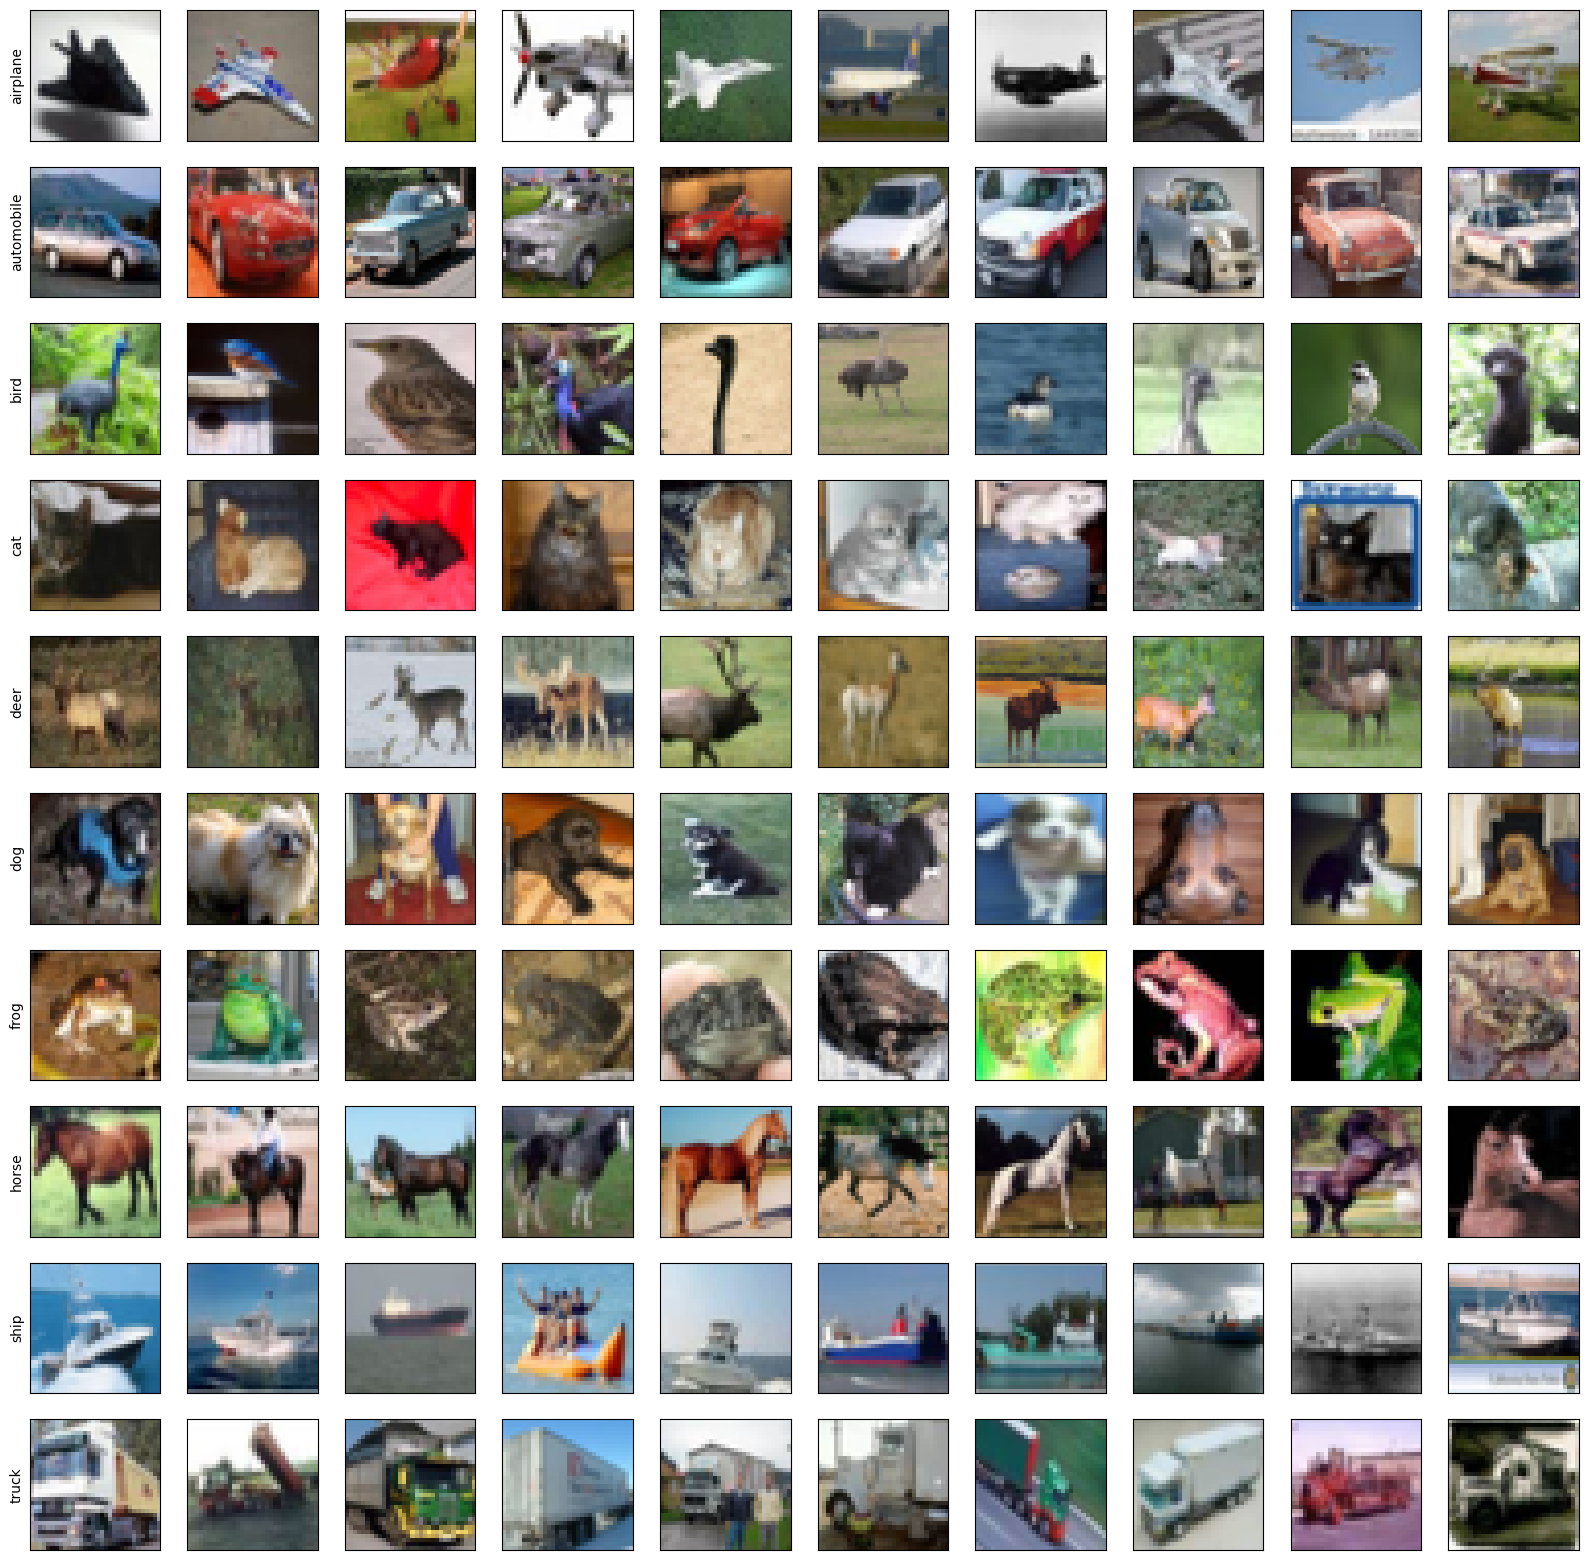

In [143]:
# show 5 images of each label and their names
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    idx = np.where(train_labels == i)[0]
    for j in range(10):
        axes[i][j].imshow(train_imgs[idx[j]])
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
    axes[i][0].set_ylabel(meta['label_names'][i])

In [144]:
# Implement Nearest Neighbor algorithm for image recognition.
# The algorithm is to find the closest image in the training set to the test image.

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

classifiers = [
    ('KNN with L1 distance', KNeighborsClassifier(n_neighbors=1, p=1, n_jobs=-1)),
    ('KNN with L2 distance', KNeighborsClassifier(n_neighbors=1, p=2, n_jobs=-1)),
]

def predict(classifiers, train_imgs, train_labels, test_imgs, test_labels):
    train_imgs = train_imgs.reshape((50000, -1))
    test_imgs = test_imgs.reshape((10000, -1))
    for name, model in classifiers:
        model.fit(train_imgs, train_labels.ravel())
        pred = model.predict(test_imgs)
        acc = accuracy_score(test_labels, pred)
        print('Accuracy of {}: {}'.format(name, acc))

In [145]:
# predict(classifiers, train_imgs, train_labels, test_imgs, test_labels)

# kNN with GPU

In [146]:
from cuml.neighbors import NearestNeighbors

classifiers = [
    ('NN with L1 distance', NearestNeighbors(n_neighbors=1, verbose=True, metric='l1')),
    ('NN with L2 distance', NearestNeighbors(n_neighbors=1, verbose=True, metric='l2')),
    ('NN with cosine', NearestNeighbors(n_neighbors=1, verbose=True, metric='cosine')),
]

def predict(classifiers, train_imgs, train_labels, test_imgs, test_labels):
    train_imgs = train_imgs.reshape((50000, -1))
    test_imgs = test_imgs.reshape((10000, -1))

    # shuffle data
    np.random.seed(0)
    np.random.shuffle(train_imgs)
    np.random.seed(0)
    np.random.shuffle(train_labels)
    np.random.seed(0)
    np.random.shuffle(test_imgs)
    np.random.seed(0)
    np.random.shuffle(test_labels)
    
    # combination of train img and label
    train = np.hstack((train_imgs, train_labels))
    test = np.hstack((test_imgs, test_labels))
    
    accs = []

    for name, model in classifiers:
        model.fit(train)
        distance, indices = model.kneighbors(test, n_neighbors=1, return_distance=True)
        
        pred = train_labels[indices]
        
        pred = pred.reshape((10000, 1))
        acc = accuracy_score(test_labels, pred)
        print('Accuracy of {}: {}'.format(name, acc))
        accs.append(acc)
    
    return accs


In [147]:
predict(classifiers, train_imgs, train_labels, test_imgs, test_labels)

Accuracy of NN with L1 distance: 0.3862
Accuracy of NN with L2 distance: 0.3539
Accuracy of NN with cosine: 0.3673


[0.3862, 0.3539, 0.3673]

# Image Processing

In [148]:
# 1. to gray scale

from skimage.color import rgb2gray
train_gray = rgb2gray(train_imgs)
test_gray = rgb2gray(test_imgs)


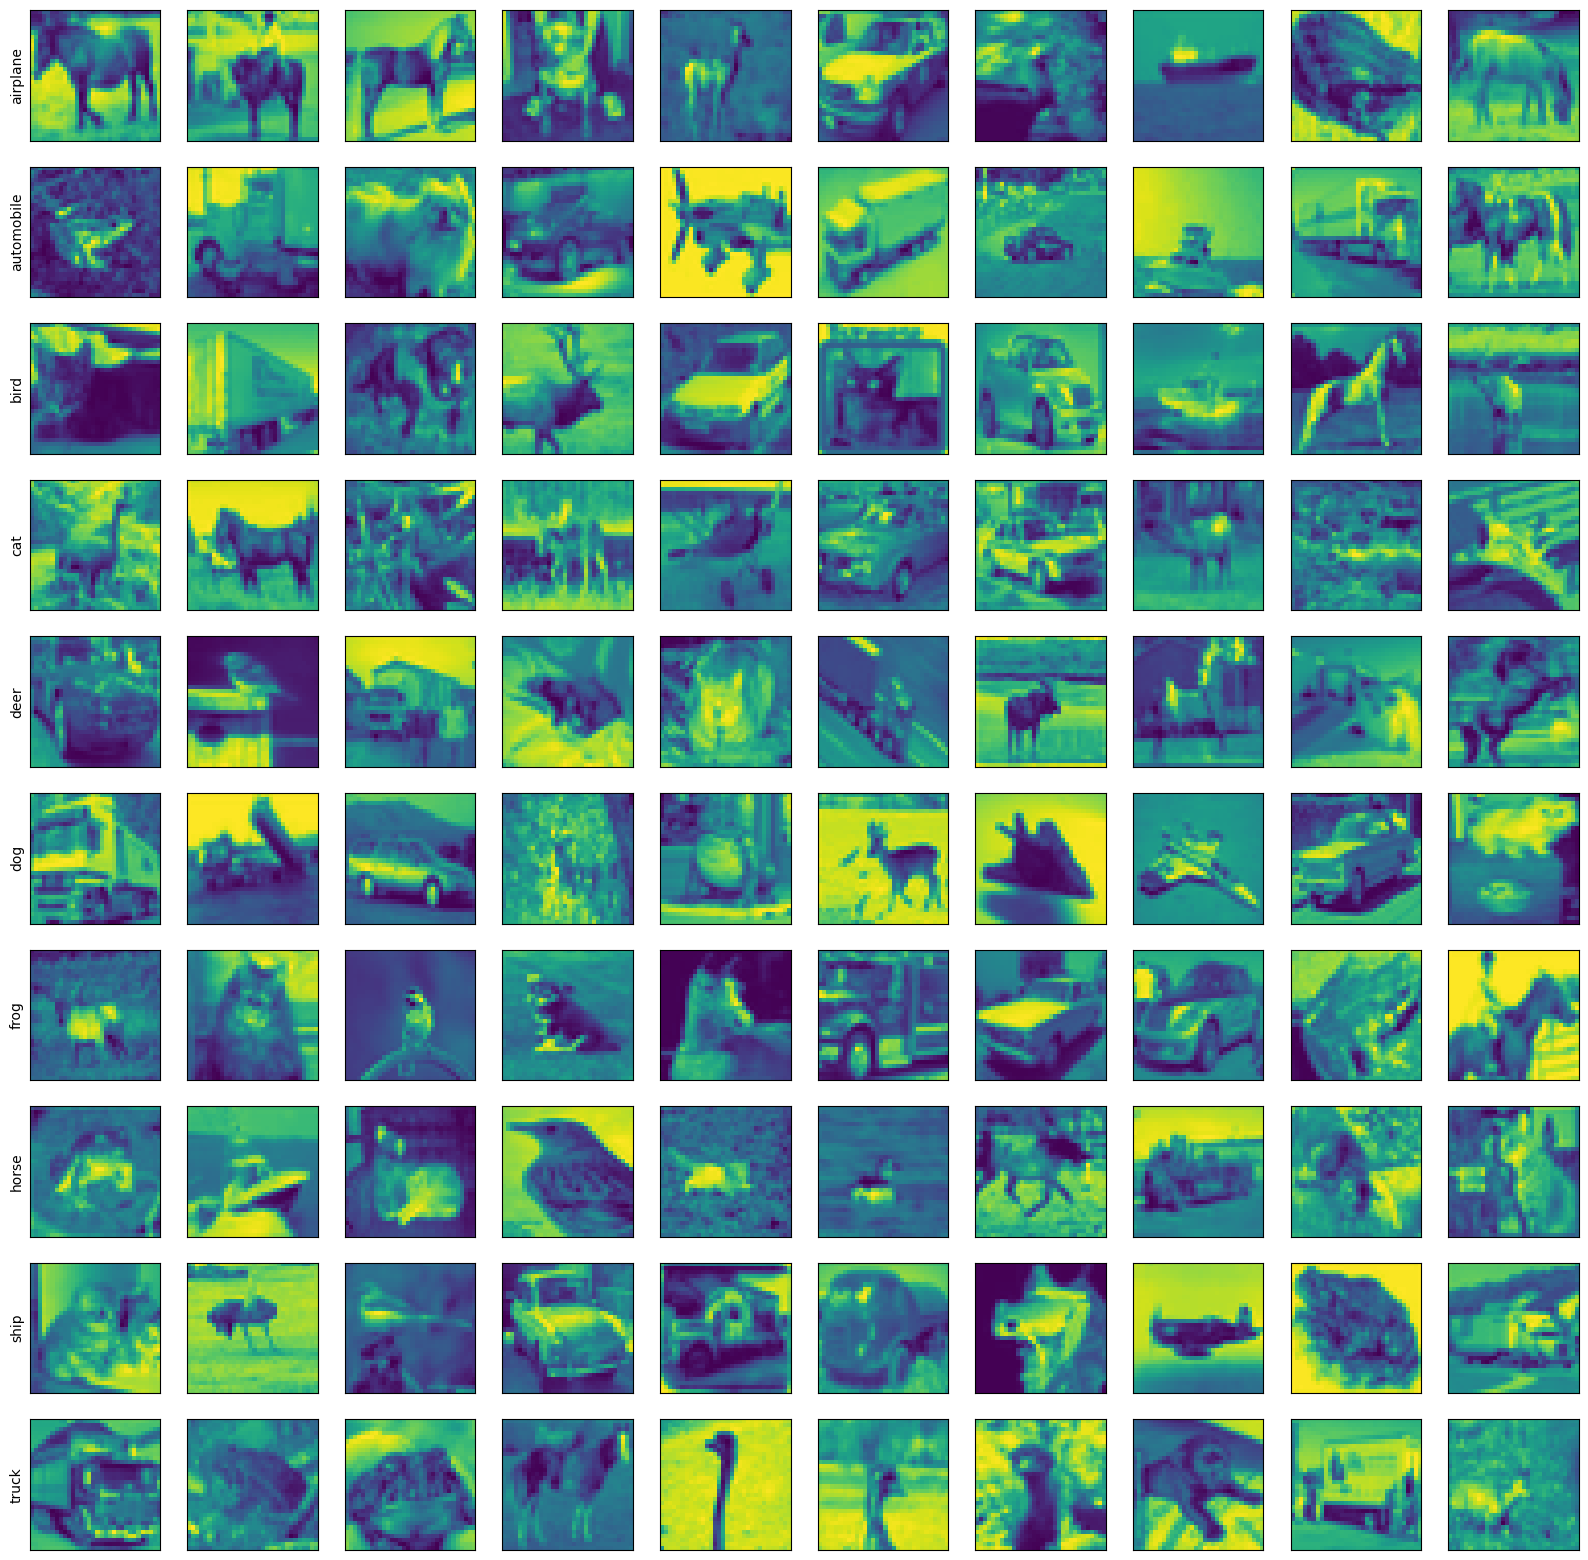

In [149]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    idx = np.where(train_labels == i)[0]
    for j in range(10):
        axes[i][j].imshow(train_gray[idx[j]])
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
    axes[i][0].set_ylabel(meta['label_names'][i])

In [150]:
predict(classifiers, train_gray, train_labels, test_gray, test_labels)

Accuracy of NN with L1 distance: 0.196
Accuracy of NN with L2 distance: 0.4847
Accuracy of NN with cosine: 0.3311


[0.196, 0.4847, 0.3311]

In [151]:
# 2. to binary
train_binary = np.where(train_gray > 0.5, 1, 0)
test_binary = np.where(test_gray > 0.5, 1, 0)

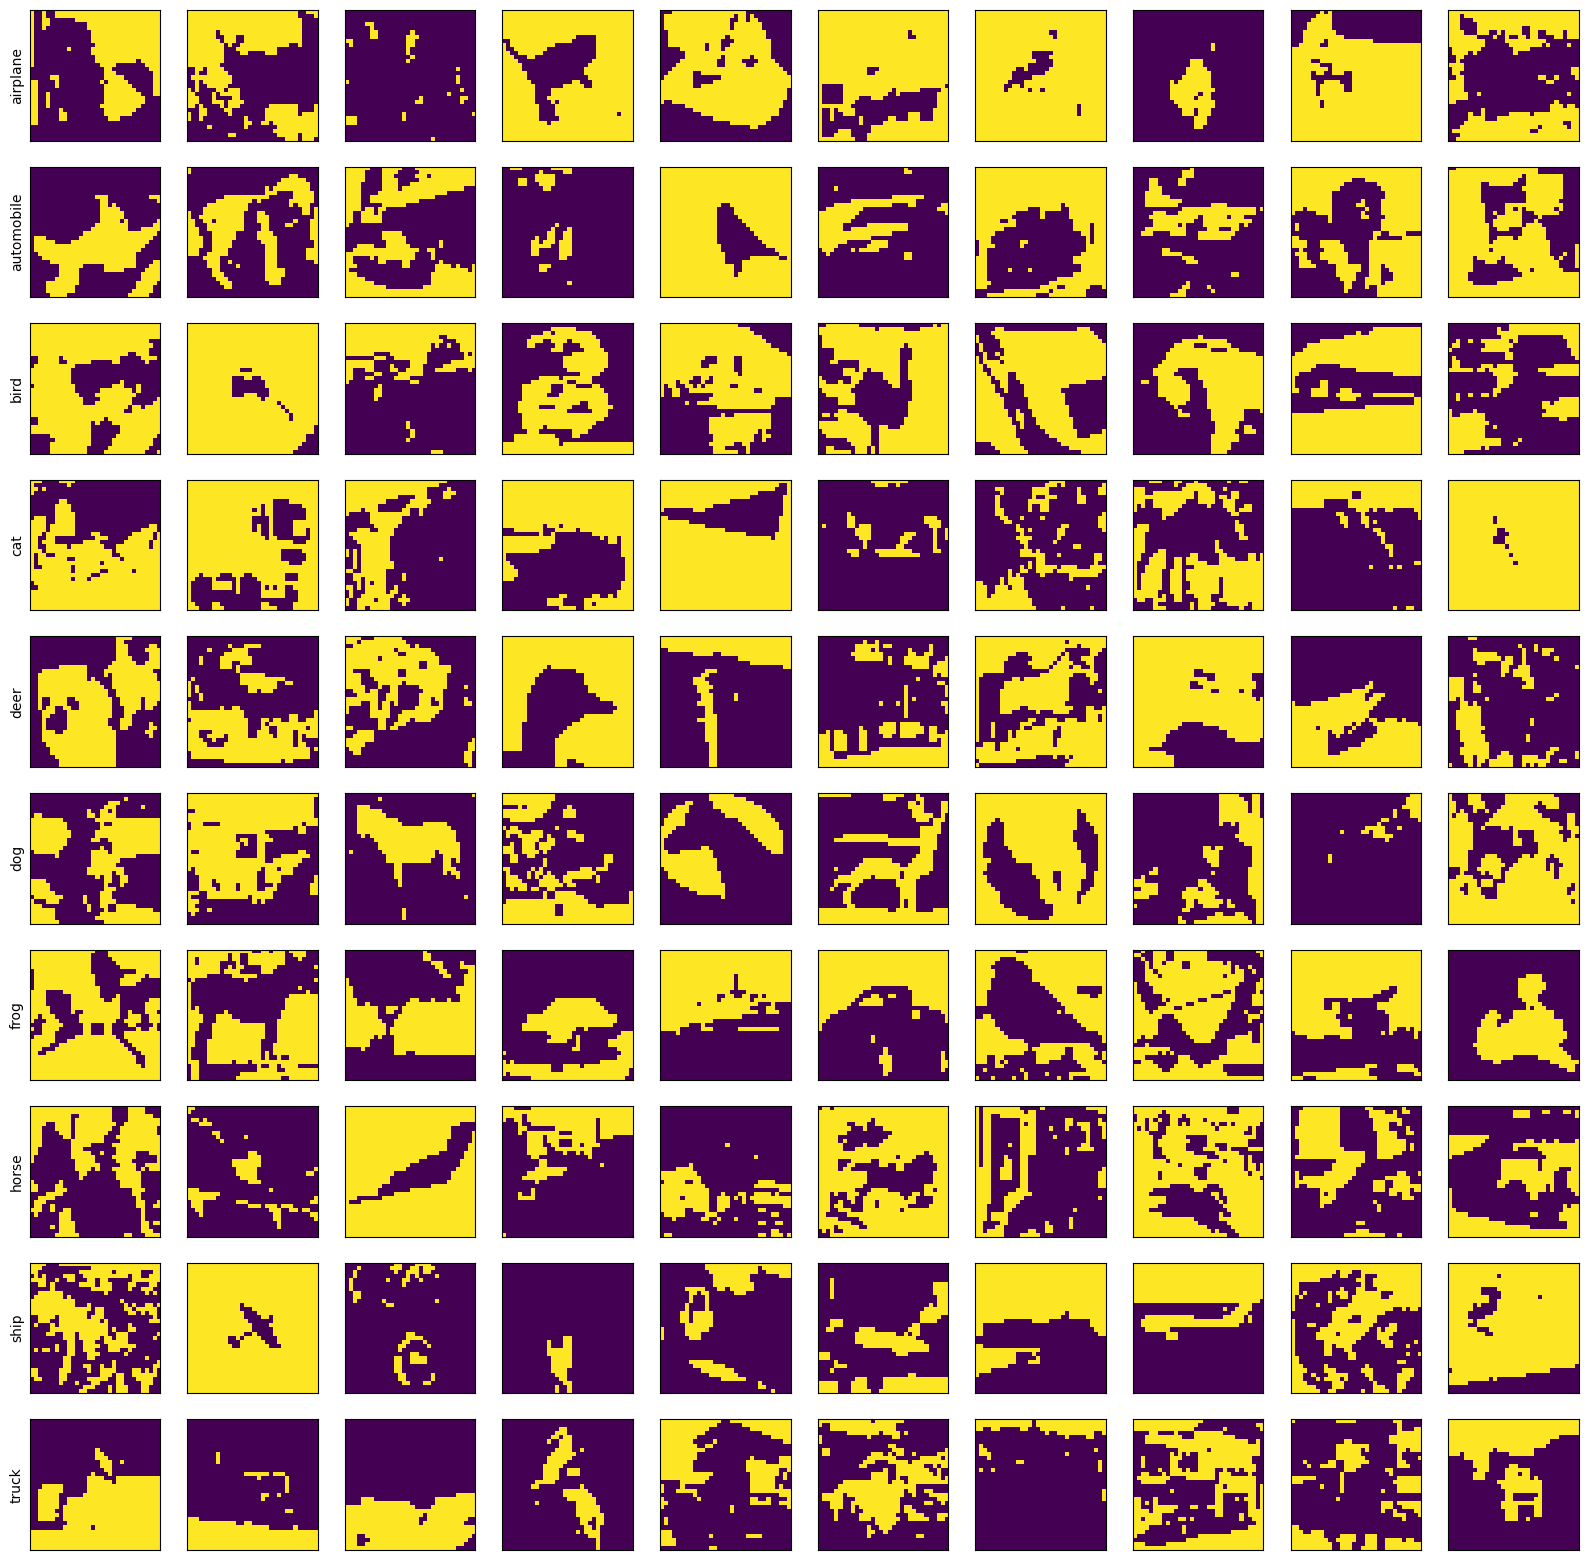

In [152]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    idx = np.where(train_labels == i)[0]
    for j in range(10):
        axes[i][j].imshow(train_binary[idx[j]])
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
    axes[i][0].set_ylabel(meta['label_names'][i])

In [153]:
predict(classifiers, train_binary, train_labels, test_binary, test_labels)

Accuracy of NN with L1 distance: 0.1626
Accuracy of NN with L2 distance: 0.2551
Accuracy of NN with cosine: 0.2167


[0.1626, 0.2551, 0.2167]

In [154]:
# 3. to HSV
from skimage.color import rgb2hsv
train_hsv = rgb2hsv(train_imgs)
test_hsv = rgb2hsv(test_imgs)

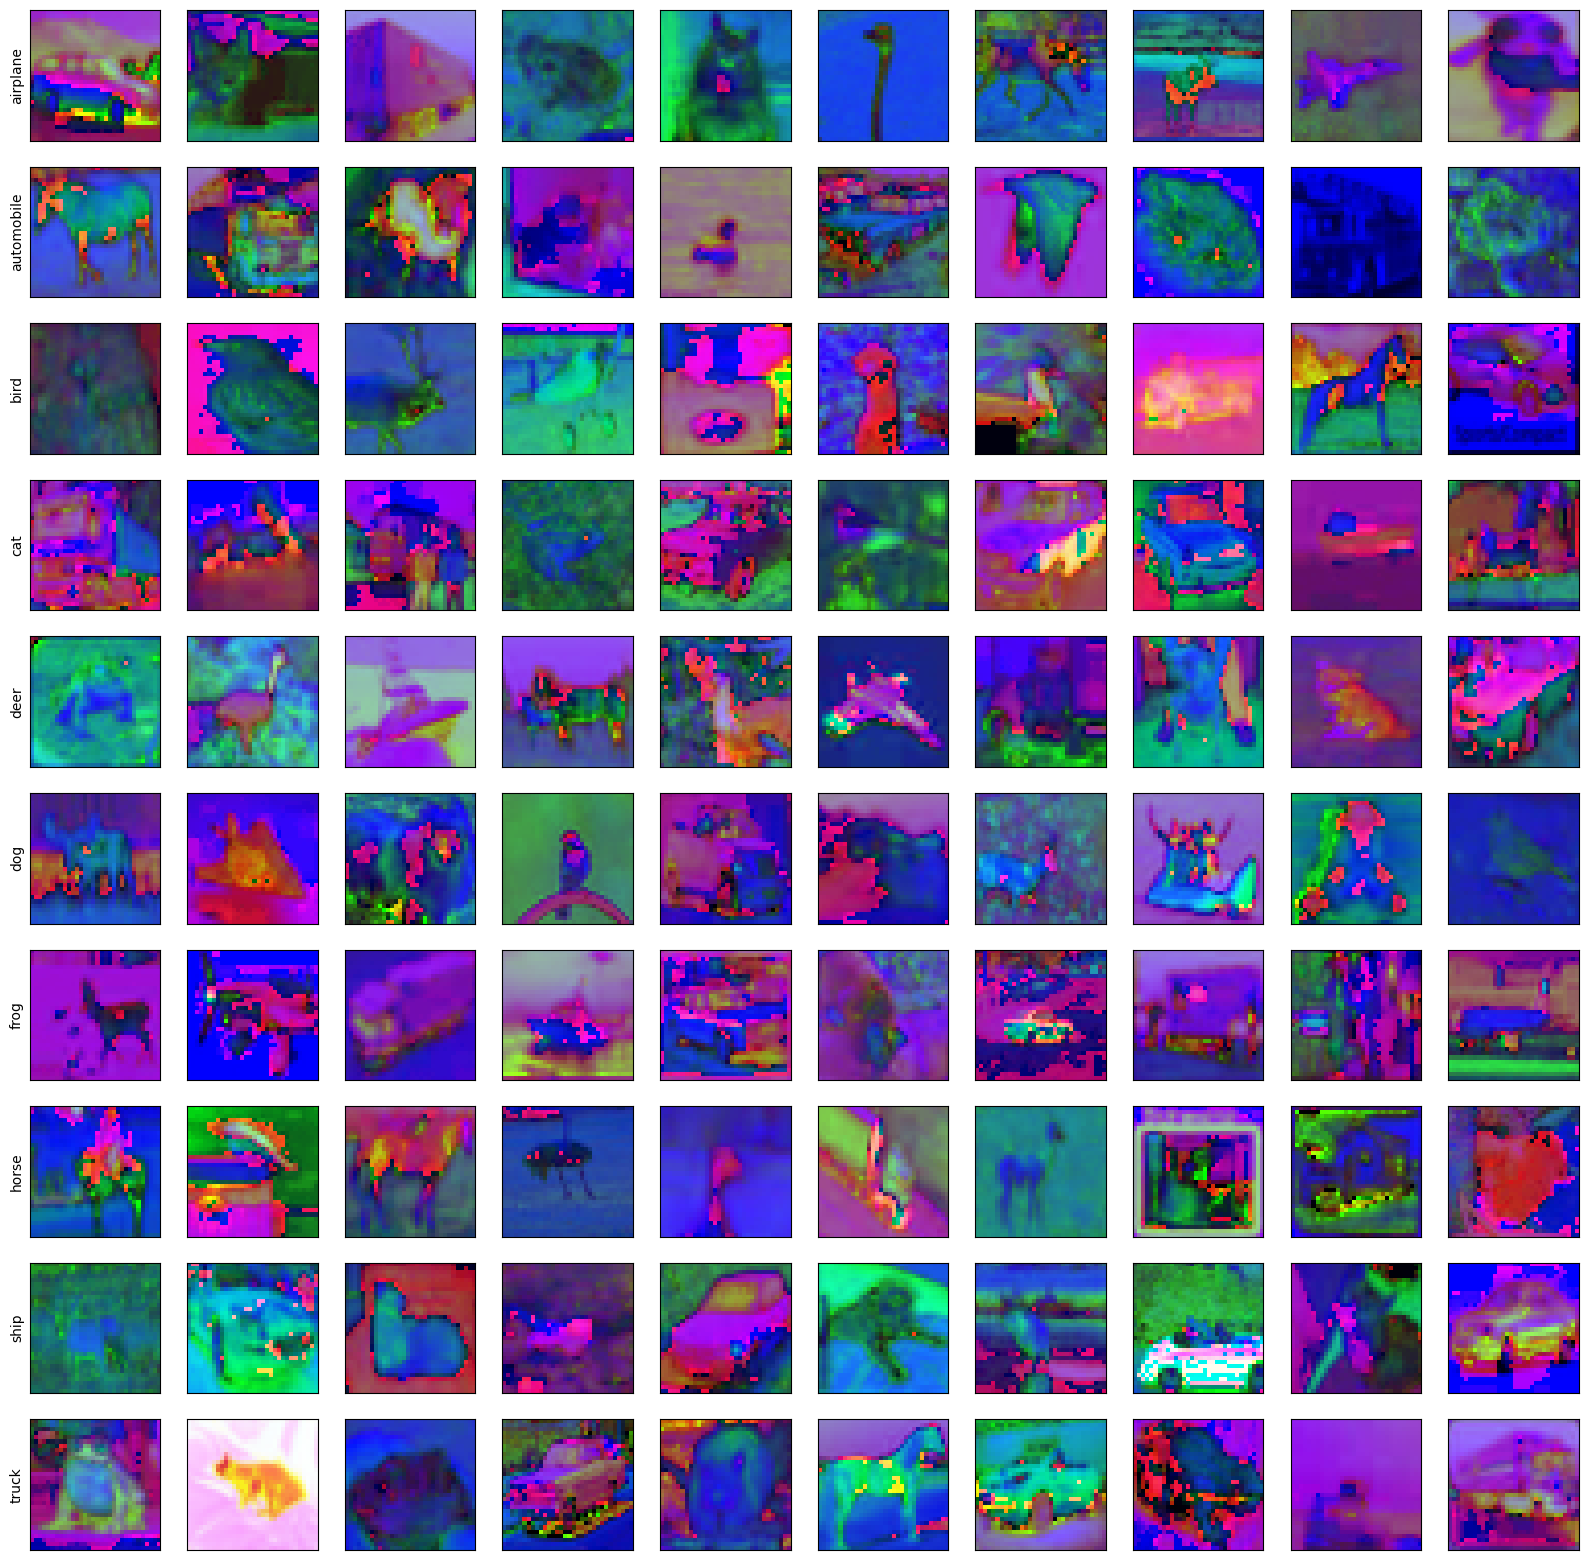

In [155]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    idx = np.where(train_labels == i)[0]
    for j in range(10):
        axes[i][j].imshow(train_hsv[idx[j]])
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
    axes[i][0].set_ylabel(meta['label_names'][i])

In [156]:
predict(classifiers, train_hsv, train_labels, test_hsv, test_labels)

Accuracy of NN with L1 distance: 0.1264
Accuracy of NN with L2 distance: 0.2932
Accuracy of NN with cosine: 0.2677


[0.1264, 0.2932, 0.2677]

# Edge Map of Image

In [157]:
# edge map of function
from skimage.feature import canny
train_edge = np.array([canny(img) for img in train_gray])
test_edge = np.array([canny(img) for img in test_gray])

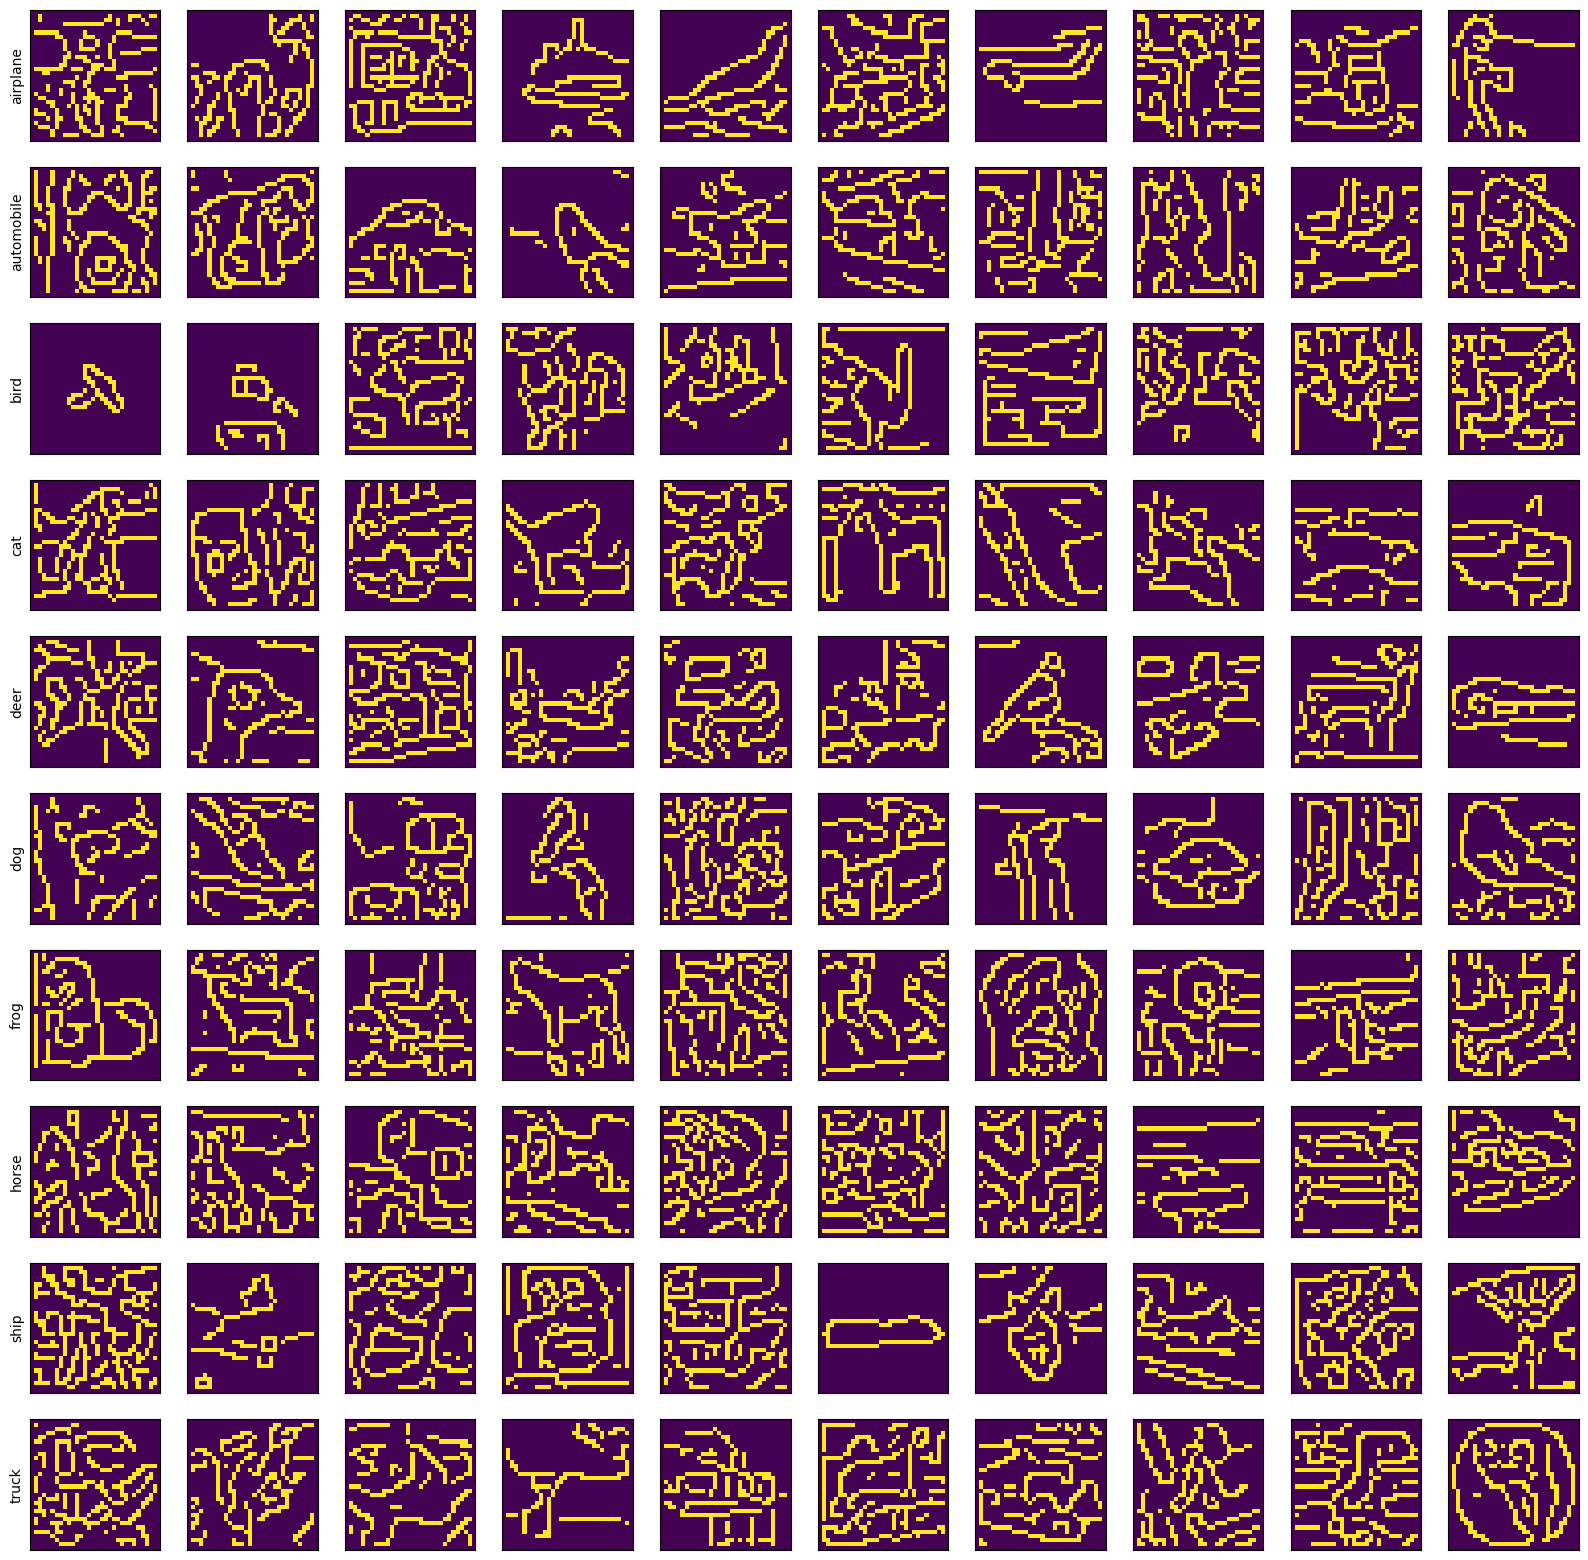

In [158]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    idx = np.where(train_labels == i)[0]
    for j in range(10):
        axes[i][j].imshow(train_edge[idx[j]])
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
    axes[i][0].set_ylabel(meta['label_names'][i])

In [159]:
predict(classifiers, train_edge, train_labels, test_edge, test_labels)

Accuracy of NN with L1 distance: 0.2373
Accuracy of NN with L2 distance: 0.3282
Accuracy of NN with cosine: 0.1511


[0.2373, 0.3282, 0.1511]

In [160]:
# hog

from skimage.feature import hog

train_hog = []
for img in train_gray:
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True)
    train_hog.append(hog_image)
train_hog = np.array(train_hog)

test_hog = []
for img in test_gray:
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True)
    test_hog.append(hog_image)
test_hog = np.array(test_hog)

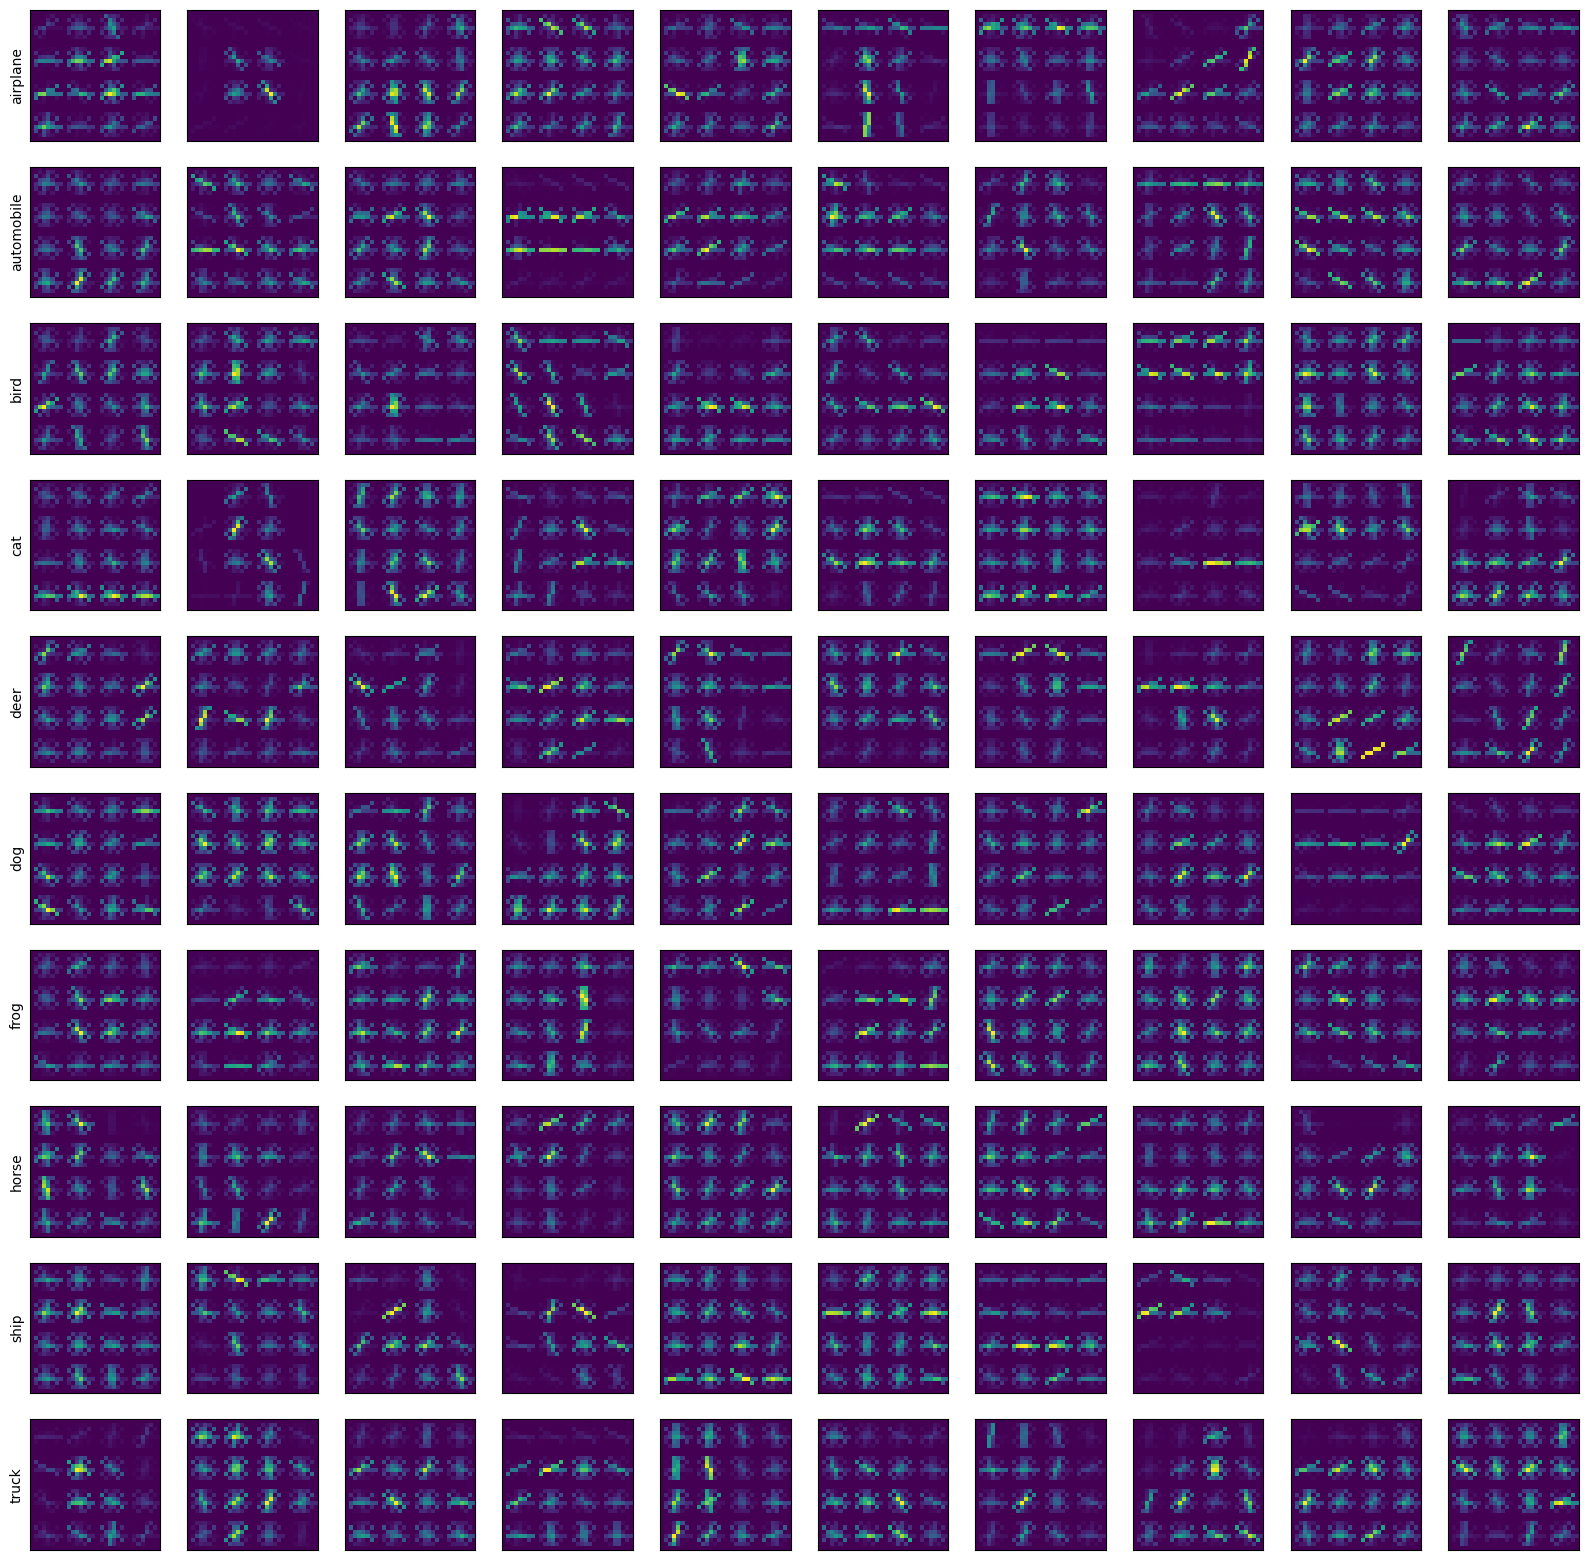

In [161]:
# plot hog
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    idx = np.where(train_labels == i)[0]
    for j in range(10):
        axes[i][j].imshow(train_hog[idx[j]])
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
    axes[i][0].set_ylabel(meta['label_names'][i])

In [162]:
predict(classifiers, train_hog, train_labels, test_hog, test_labels)

Accuracy of NN with L1 distance: 0.944
Accuracy of NN with L2 distance: 1.0
Accuracy of NN with cosine: 0.4038


[0.944, 1.0, 0.4038]

In [163]:
# different simga for canny
train_edge = np.array([canny(img, sigma=0.1) for img in train_gray])
test_edge = np.array([canny(img, sigma=0.1) for img in test_gray])

print(train_edge.shape, test_edge.shape)

predict(classifiers, train_edge, train_labels, test_edge, test_labels)

(50000, 32, 32) (10000, 32, 32)
Accuracy of NN with L1 distance: 0.2408
Accuracy of NN with L2 distance: 0.3576
Accuracy of NN with cosine: 0.1668


[0.2408, 0.3576, 0.1668]

# PCA

In [164]:
# pca

from cuml import PCA

pca = PCA(whiten=True, n_components=1)
pca.fit(train_gray.reshape((50000, -1)).astype(np.float32))

train_pca = pca.transform(train_gray.reshape((50000, -1)).astype(np.float32))
test_pca = pca.transform(test_gray.reshape((10000, -1)).astype(np.float32))


In [165]:
predict(classifiers, train_pca, train_labels, test_pca, test_labels)

Accuracy of NN with L1 distance: 1.0
Accuracy of NN with L2 distance: 1.0
Accuracy of NN with cosine: 0.2141


[1.0, 1.0, 0.2141]

Accuracy of NN with L1 distance: 1.0
Accuracy of NN with L2 distance: 1.0
Accuracy of NN with cosine: 0.2158
Accuracy of NN with L1 distance: 1.0
Accuracy of NN with L2 distance: 1.0
Accuracy of NN with cosine: 0.2264
Accuracy of NN with L1 distance: 0.9808
Accuracy of NN with L2 distance: 0.9914
Accuracy of NN with cosine: 0.206
Accuracy of NN with L1 distance: 0.93
Accuracy of NN with L2 distance: 0.9507
Accuracy of NN with cosine: 0.1803
Accuracy of NN with L1 distance: 0.8985
Accuracy of NN with L2 distance: 0.9108
Accuracy of NN with cosine: 0.1765
Accuracy of NN with L1 distance: 0.8521
Accuracy of NN with L2 distance: 0.8754
Accuracy of NN with cosine: 0.1679
Accuracy of NN with L1 distance: 0.8213
Accuracy of NN with L2 distance: 0.8415
Accuracy of NN with cosine: 0.164
Accuracy of NN with L1 distance: 0.7822
Accuracy of NN with L2 distance: 0.8102
Accuracy of NN with cosine: 0.1588
Accuracy of NN with L1 distance: 0.7575
Accuracy of NN with L2 distance: 0.7819
Accuracy of NN w

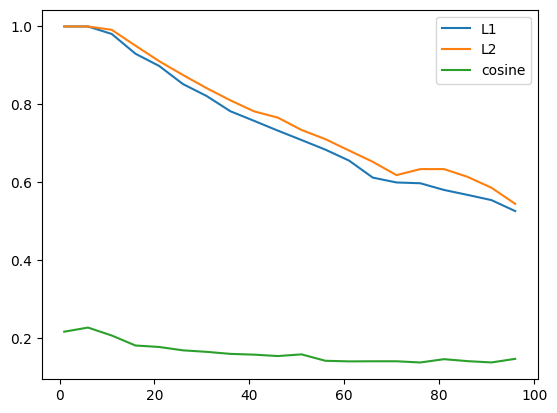

In [166]:
# try different number of components and plot the accuracy

n=[i for i in range(1, 100, 5)]
acc = {
    'L1': [],
    'L2': [],
    'cosine': [],
}
# shuffle data
np.random.seed(0)
np.random.shuffle(train_gray)
np.random.seed(0)
np.random.shuffle(train_labels)
np.random.seed(0)
np.random.shuffle(test_gray)
np.random.seed(0)
np.random.shuffle(test_labels)

for i in n:
    pca = PCA(whiten=True, n_components=i)
    pca.fit(train_gray.reshape((50000, -1)).astype(np.float32))

    train_pca = pca.transform(train_gray.reshape((50000, -1)).astype(np.float32))
    test_pca = pca.transform(test_gray.reshape((10000, -1)).astype(np.float32))

    accs = predict(classifiers, train_pca, train_labels, test_pca, test_labels)
    acc['L1'].append(accs[0])
    acc['L2'].append(accs[1])
    acc['cosine'].append(accs[2])

plt.plot(n, acc['L1'], label='L1')
plt.plot(n, acc['L2'], label='L2')
plt.plot(n, acc['cosine'], label='cosine')
plt.legend()
plt.show()

    

# Different k for KNN

In [167]:
def predict(classifiers, train_imgs, train_labels, test_imgs, test_labels, title):
    train_imgs = train_imgs.reshape((50000, -1))
    test_imgs = test_imgs.reshape((10000, -1))

    # shuffle data
    np.random.seed(0)
    np.random.shuffle(train_imgs)
    np.random.seed(0)
    np.random.shuffle(train_labels)
    np.random.seed(0)
    np.random.shuffle(test_imgs)
    np.random.seed(0)
    np.random.shuffle(test_labels)
    

    # combination of train img and label
    train = np.hstack((train_imgs, train_labels))
    test = np.hstack((test_imgs, test_labels))

    accs={}
    for name, model in classifiers:
        accs[name] = []
        model.fit(train)
        for i in range(1,21):
            distance, indices = model.kneighbors(test, n_neighbors=i, return_distance=True)
        
            pred = train_labels[indices]
            # find the most common label
            pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=pred)
            
            pred = pred.reshape((10000, 1))
            acc = accuracy_score(test_labels, pred)
            # print('Accuracy of {} - k: {}: {}'.format(name, i, acc))
            accs[name].append(acc)

    x_axis = np.arange(1,21)
    for name, _ in classifiers:
        plt.plot(x_axis, accs[name], label=name)
    plt.title(title)
    plt.xlabel('k')
    plt.xticks(x_axis)
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

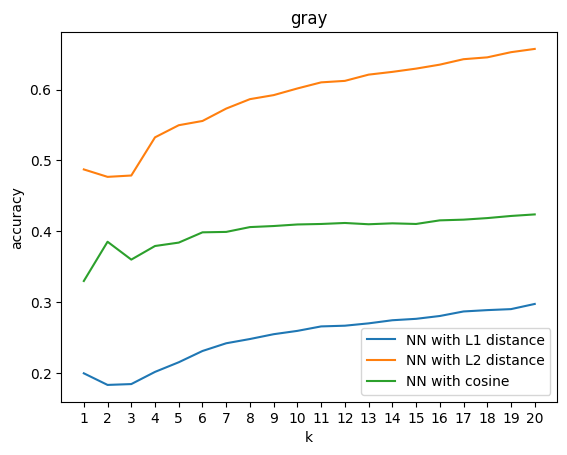

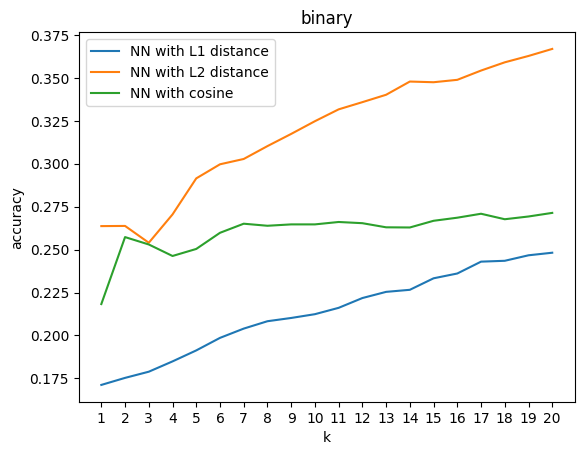

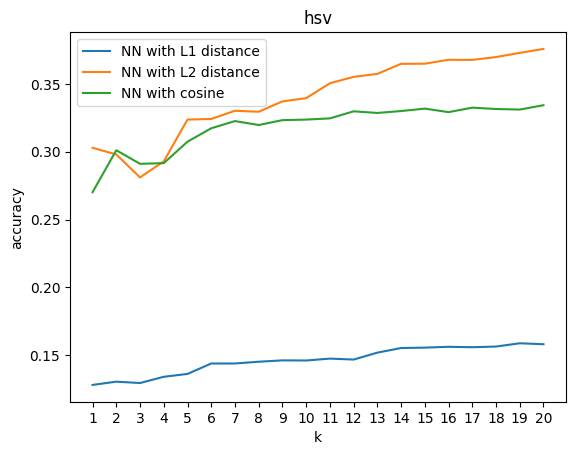

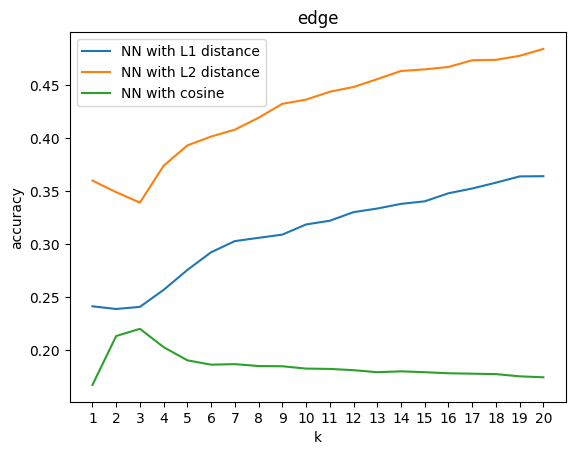

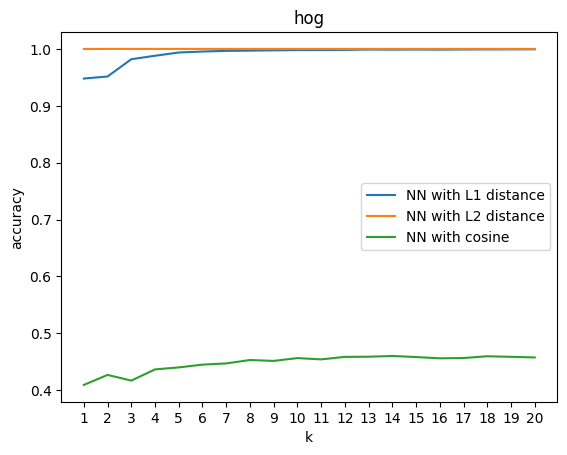

In [135]:
# re-run all predict

# 1. to gray scale
predict(classifiers, train_gray, train_labels, test_gray, test_labels, 'gray')
# 2. to binary
predict(classifiers, train_binary, train_labels, test_binary, test_labels, 'binary')

# 3. to HSV
predict(classifiers, train_hsv, train_labels, test_hsv, test_labels, 'hsv')

# edge map of function
predict(classifiers, train_edge, train_labels, test_edge, test_labels, 'edge')

# hog
predict(classifiers, train_hog, train_labels, test_hog, test_labels, 'hog')

# SVM

In [65]:
# svm
from cuml import LinearSVC

classifiers = [
    ('Linear SVM l1', LinearSVC(penalty='l1', loss='squared_hinge', tol=1e-4, C=1.0)),
    ('Linear SVM l2', LinearSVC(penalty='l2', loss='squared_hinge', tol=1e-4, C=1.0)),
]

def predict(classifiers, train_imgs, train_labels, test_imgs, test_labels):
    train_imgs = train_imgs.reshape((50000, -1))
    test_imgs = test_imgs.reshape((10000, -1))

    # shuffle the img and label
    np.random.seed(0)
    np.random.shuffle(train_imgs)
    np.random.seed(0)
    np.random.shuffle(train_labels)
    np.random.seed(0)
    np.random.shuffle(test_imgs)
    np.random.seed(0)

    # convert to float32
    train_imgs = train_imgs.astype(np.float32)
    test_imgs = test_imgs.astype(np.float32)
    for name, model in classifiers:
        model.fit(train_imgs, train_labels.ravel())
        pred = model.predict(test_imgs)
        acc = accuracy_score(test_labels, pred)
        print('Accuracy of {}: {}'.format(name, acc))

In [66]:
predict(classifiers, train_imgs, train_labels, test_imgs, test_labels)

[W] [13:47:08.864247] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [13:47:11.090091] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [13:47:11.478648] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
Accuracy of Linear SVM l1: 0.1013
[W] [13:47:12.679917] L-BFGS line search failed (code 4); stopping at the last valid step
[W] [13:47:12.745930] L-BFGS line search failed (code 4); stopping at the last valid step
[W] [13:47:12.812350] L-BFGS line search failed (code 4); stopping at the last valid step
[W] [13:47:12.878722] L-BFGS line search failed (code 4); stopping at the last valid step
[W] [13:47:12.945743] L-BFGS line search failed (code 4); stopping at the last valid step
[W] [13:47:13.012367] L-BFGS line search failed (code 4); stopping at the last valid step
[W] [13:47:13.078726] L-BFGS line search failed (code 4); stopping at the last valid step
[W] [13:47:13.145514] L-

In [67]:
from cuml import SVC

classifiers = [
    ('SVM rbf', SVC(C=1.0, kernel='rbf', gamma='auto', tol=1e-3)),
    ('SVM sigmoid', SVC(C=1.0, kernel='sigmoid', gamma='auto', tol=1e-3)),
]

predict(classifiers, train_imgs, train_labels, test_imgs, test_labels)

Accuracy of SVM rbf: 0.1
Accuracy of SVM sigmoid: 0.1


In [34]:
# gary scale
predict(classifiers, train_gray, train_labels, test_gray, test_labels)

Accuracy of SVM rbf: 0.3535
Accuracy of SVM sigmoid: 0.2545


In [35]:
# binary

predict(classifiers, train_binary, train_labels, test_binary, test_labels)

Accuracy of SVM rbf: 0.3484
Accuracy of SVM sigmoid: 0.131
